<a href="https://colab.research.google.com/github/ParitoshP702/BO_vs_RL_Pricing/blob/main/Comaprison_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import random

In [ ]:
import scipy
from scipy.optimize import minimize
from scipy.optimize import fsolve

In [ ]:
#y\ =-x^{5\ }\ +\ 12x^{4}-46x^{3}+\ 418\cdot x^{2}\ -50\cdot x\ +\ 40
true_coeff = np.array([40,-50,418,-46,12,-1])

In [ ]:
from tqdm import tqdm

In [ ]:
import torch

In [ ]:
!pip install gpytorch
import gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def func_revenue(price):
    p_arr = np.array([1,price,price**2,price**3,price**4,price**5])
    return np.sum(p_arr*true_coeff)

In [ ]:
import scipy
from scipy.stats import norm

In [ ]:
def compute_barycentre():
  def equations(p):
    p2,p3,p4,p5= p
    return (1/p2 + 1/(p2-p3)+ 1/(p2-p4) + 1/(p2-p5) + 1/(p2-1),
          1/p3 + 1/(p3-p2)+ 1/(p3-p4) + 1/(p3-p5) + 1/(p3-1),
          1/p4 + 1/(p4-p2)+ 1/(p4-p3) + 1/(p4-p5) + 1/(p4-1),
          1/p5 + 1/(p5-p3)+ 1/(p5-p4) + 1/(p5-p2) + 1/(p5-1))
  b2_init = np.random.uniform(0,1)
  b3_init = np.random.uniform(0,1)
  b4_init = np.random.uniform(0,1)
  b5_init = np.random.uniform(0,1)
  b2,b3,b4,b5 = fsolve(equations,(b2_init,b3_init,b4_init,b5_init))
  return np.array([0.,b2,b3,b4,b5,1.])

In [ ]:
barycentric_spanner = compute_barycentre()

In [ ]:
barycentric_spanner

array([0.        , 0.88252766, 0.11747234, 0.35738424, 0.64261576,
       1.        ])

In [ ]:
def Thompson():
    epsilon_array = []
    def p_vector(p):
        p_vec = np.array([1,p,p**2,p**3,p**4,p**5])
        return p_vec.reshape(len(p_vec),1)

    def g_fun(p,*args):
          p_vec = np.array([1,p,p**2,p**3,p**4,p**5])
          coeff_array = args
          return -np.sum(coeff_array*p_vec)
    var_cov_inv = np.zeros((6,6))
    for b in barycentric_spanner:
        b_vec = p_vector(b)
        var_cov_inv += b_vec@np.transpose(b_vec)

    var_cov = np.linalg.inv(var_cov_inv)
    mu_ = np.array([0,0,0,0,0,0])
    pl = 0.
    ph = 11.194
    w = np.random.multivariate_normal(np.array([0,0,0,0,0,0]),var_cov)
    price_estimate = minimize(g_fun,x0 = np.array([random.random()]),args = (w),bounds = [(pl,ph)])["x"][0]
    p_array = []
    p_curr = p_vector(price_estimate)
    p_array.append(price_estimate)
    reven_array = []
    def update_mean(rev,p_ar):
      sum = 0
      for i in range(len(rev)):
          price = p_ar[i]
          p = p_vector(price)
          sum += rev[i]*p/100
      return sum

    def update_mat(p_ar):
        sum = 0
        for i in range(len(p_ar)):
            price = p_ar[i]
            p = p_vector(price)
            sum += (p@np.transpose(p))/100
        return sum

    for i in tqdm(range(100)):
        rev_curr = (true_coeff.reshape(1,6)@p_curr)[0][0]+np.random.normal(0,10)
        reven_array.append(rev_curr)
        var_copy = var_cov
        mu_copy = mu_
        var_cov = np.linalg.inv(np.linalg.inv(var_copy) + update_mat(p_array))
        # np.linalg.eig(var_cov)
        min_ev = np.min(np.linalg.eig(var_cov)[0])
        if min_ev <= 0:
            var_cov += np.diag(np.array([1e-5,1e-5,1e-5,1e-5,1e-5,1e-5]))
        mu_ = var_cov@(np.linalg.inv(var_copy)@mu_copy.reshape(6,1) + update_mean(reven_array,p_array))
    #     mu_ = var_cov@( rev_curr*p_curr/100)
        mu_ = mu_.reshape(6,)
        w_sample = np.random.multivariate_normal(mu_,var_cov)
        price_estimate = minimize(g_fun,x0 = np.array([random.random()]),args = (w_sample),bounds = [(pl,ph)])["x"][0]
        p_curr = p_vector(price_estimate)
        p_array.append(price_estimate)
        epsilon =np.max([0,np.min(19866.752 - np.array(reven_array))])
        epsilon_array.append(epsilon)
    return np.array(epsilon_array)


In [ ]:
 def BayesOpt():
    epsilon_array = []
    train_x = torch.rand(2)
    train_y = []
    for price in train_x.numpy():
      train_y.append(func_revenue(price))
    train_y = np.array(train_y)
    train_y = torch.tensor(train_y)
    class ExactGPModel(gpytorch.models.ExactGP):
          def __init__(self, train_x, train_y, likelihood):
              super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
              self.mean_module = gpytorch.means.ConstantMean()
              self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

          def forward(self, x):
              mean_x = self.mean_module(x)
              covar_x = self.covar_module(x)
              return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    def tune_hyperparameter(train_x,train_y):
          # print(train_x)
          # print(train_y)
          likelihood = gpytorch.likelihoods.GaussianLikelihood()
          model = ExactGPModel(train_x, train_y, likelihood)
          model.train()
          likelihood.train()

          optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)

          mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)

          training_iter = 100

          for i in range(training_iter):
                ##zero greadients from previous iterations

                optimizer.zero_grad()
                ##output from model

                output = model(train_x)

                ##calculate loss and backprop gradients

                loss = -mll(output,train_y)
                # print(loss)

                loss.backward()

                optimizer.step()

    tune_hyperparameter(train_x,train_y)

    def acquisition(model,train_x,Xsamples):
          train_x = torch.tensor(train_x)
          Xsamples = torch.tensor(Xsamples)
          # print(Xsamples)
          model.double()
          yhat = model(train_x).mean.detach().numpy()
          # print(yhat)
          best = max(yhat)
          model.eval();
          likelihood.eval();
          with torch.no_grad():
            f_preds = model(Xsamples)
          mu = (f_preds.mean).detach().numpy()
          std = ((f_preds.variance).detach().numpy()) ** 0.5
          # print(mu)
          # print(std)
          probs = (mu-best)*norm.cdf((mu-best)/(std+1e-9)) + std*norm.pdf((mu-best)/(std+1e-9))
          return probs
    def opt_acquisition(model,train_x):
          Xsamples = np.random.uniform(low = 0,high = 11.194,size = 10)
          scores = acquisition(model,train_x,Xsamples)
          ix = np.argmax(scores)
          # print(ix)
          return Xsamples[ix]



    train_x = train_x.numpy()
    train_y = train_y.numpy()
    for i in range(100):

      point = opt_acquisition(model,train_x)
      true_val = func_revenue(point)
      # print(true_val)
      # print(point)
      # train_x = train_x.numpy()
      # train_y = train_y.numpy()
      train_x = np.hstack((train_x,[point]))
      train_y = np.hstack((train_y,[true_val]))
      # print(train_x)
      # print(train_y)
      tune_hyperparameter(torch.tensor(train_x),torch.tensor(train_y))
      reven_array = train_y[2:]
      epsilon =np.max([0,np.min(19866.752 - np.array(reven_array))])
      epsilon_array.append(epsilon)
    return np.array(epsilon_array)

In [ ]:
def ParameterSpace():
    epsilon_array = []
    mu_ = np.random.uniform(size = 5)
    sigma_ = np.random.uniform(size= 5)
    def p_vector(p):
        p_arr = np.array([1,p,p**2,p**3,p**4])
        return p_arr

    def g_fun(p,*args):
        p_vec = np.array([1,p,p**2,p**3,p**4])
        coeff_array = args
        return -np.sum(coeff_array*p_vec)
    w = mu_ + sigma_ * np.random.normal(0,1)
    pl = 0.3
    ph = 10
    price_estimate = minimize(g_fun,x0 = np.array([random.random()]),args = (w),bounds = [(pl,ph)])["x"][0]
    p_array = []
    reven_array_true = []
    p_curr = p_vector(price_estimate)
    p_array.append(price_estimate)
    alpha = 0.05
    for t in tqdm(range(1,101)):
        rev_curr = (true_coeff.reshape(1,len(true_coeff))@p_curr.reshape(len(p_curr),1))[0][0]+np.random.normal(0,10)
    #     rev_curr_predict = (w.reshape(1,5)@p_curr)[0][0]
    #     print(rev_curr)
        reven_array_true.append(rev_curr)
    #     reven_array_predicted.append(rev_curr_predict
        sigma_ = sigma_*np.random.normal(0,1)
        mu = torch.tensor(mu_.reshape(len(mu_),1),requires_grad = True)
        sigma = torch.tensor(sigma_.reshape(len(sigma_),1),requires_grad = True)
        sum = torch.tensor([0])
        for i in range(len(p_array)):
            p_vec = p_vector(p_array[i])
            p_vec = p_vec.reshape(len(p_vec),1)
            p_vec = torch.tensor(p_vec)
            revenue = reven_array_true[i]
            sum =sum + ((torch.transpose(mu+sigma,0,1)@p_vec - torch.tensor([[revenue]]))**2)/t
        # print(sum.size())
        external_grad = torch.tensor([[1]])
        sum.backward(gradient = external_grad)
        mu_ = (mu- alpha*mu.grad).detach().numpy()
        sigma_ = (sigma - alpha*sigma.grad).detach().numpy()
        w = mu_ + sigma_ * np.random.normal(0,1)
    #     print(w)
        price_estimate = minimize(g_fun,x0 = np.array([random.random()]),args = (w),bounds = [(pl,ph)])["x"][0]
        p_array.append(price_estimate)
        p_curr = p_vector(price_estimate)
        # print(p_curr)
        epsilon =np.max([0,np.min(19866.752 - np.array(reven_array_true))])
        epsilon_array.append(epsilon)
    return np.array(epsilon_array)


In [ ]:
best_till_now_BO = []
for i in range(10):
  best_till_now_BO.append(BayesOpt())

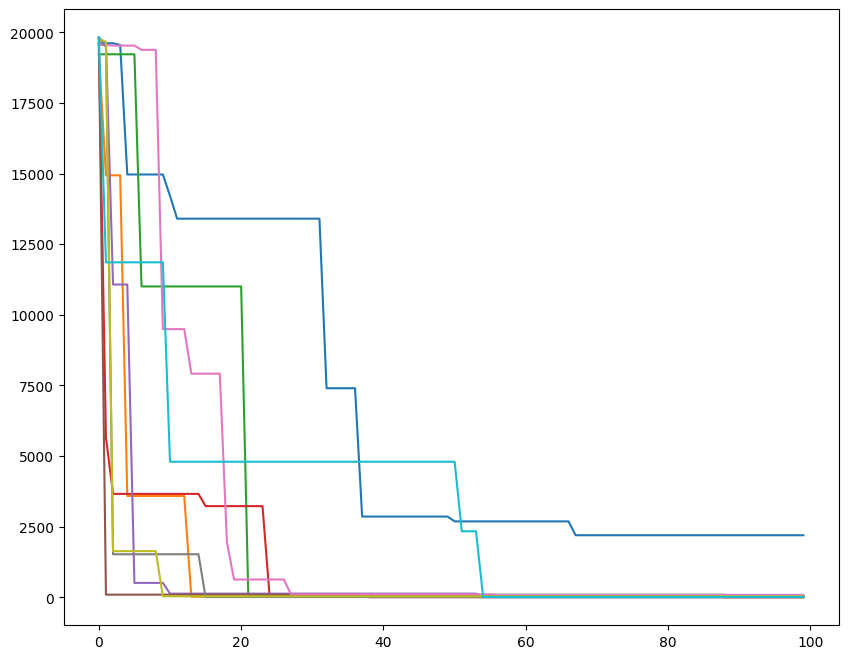

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.plot(best_till_now_BO[0])
plt.plot(best_till_now_BO[1])
plt.plot(best_till_now_BO[2])
plt.plot(best_till_now_BO[3])
plt.plot(best_till_now_BO[4])
plt.plot(best_till_now_BO[5])
plt.plot(best_till_now_BO[6])
plt.plot(best_till_now_BO[7])
plt.plot(best_till_now_BO[8])
plt.plot(best_till_now_BO[9])

In [ ]:
best_till_now_thmp = []
for i in range(10):
  best_till_now_thmp.append(Thompson())

<ipython-input-35-f4c1e1fdca13>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_vec = np.array([1,p,p**2,p**3,p**4,p**5])
  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-35-f4c1e1fdca13>:55: RuntimeWarning: covariance is not positive-semidefinite.
  w_sample = np.random.multivariate_normal(mu_,var_cov)
100%|██████████| 100/100 [00:00<00:00, 240.00it/s]


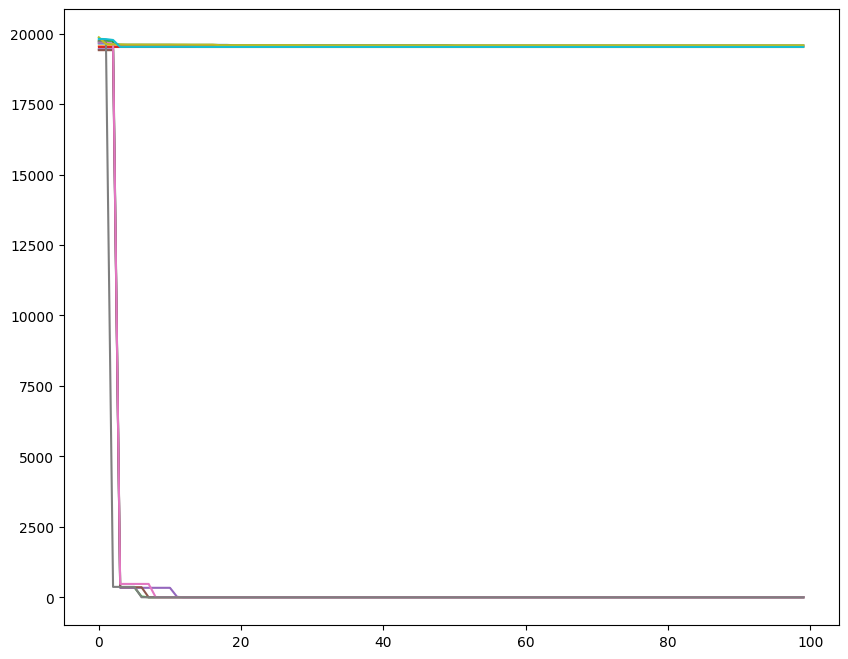

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(best_till_now_thmp[0])
plt.plot(best_till_now_thmp[1])
plt.plot(best_till_now_thmp[2])
plt.plot(best_till_now_thmp[3])
plt.plot(best_till_now_thmp[4])
plt.plot(best_till_now_thmp[5])
plt.plot(best_till_now_thmp[6])
plt.plot(best_till_now_thmp[7])
plt.plot(best_till_now_thmp[8])
plt.plot(best_till_now_thmp[9])

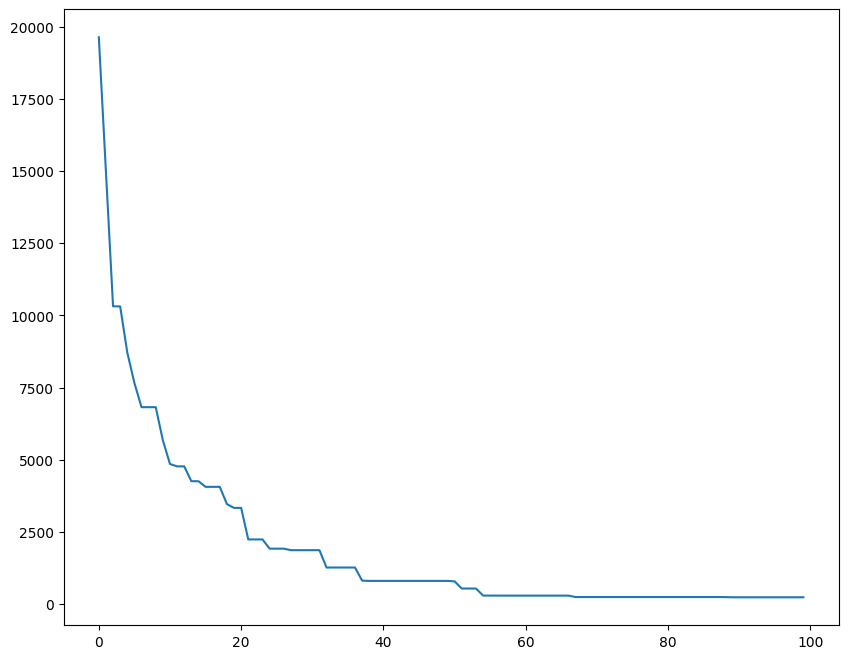

In [ ]:
best_till_Bo_averaged = np.mean(best_till_now_BO,axis = 0)
plt.figure(figsize = (10,8))
plt.plot(best_till_Bo_averaged)

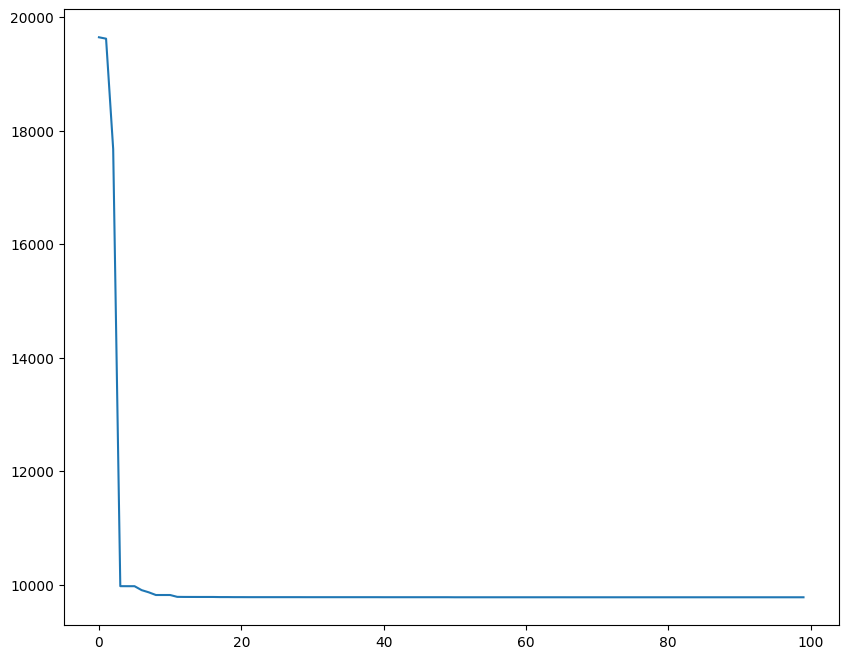

In [ ]:
best_till_tmp_avg = np.mean(best_till_now_thmp,axis = 0)
plt.figure(figsize = (10,8))
plt.plot(best_till_tmp_avg)

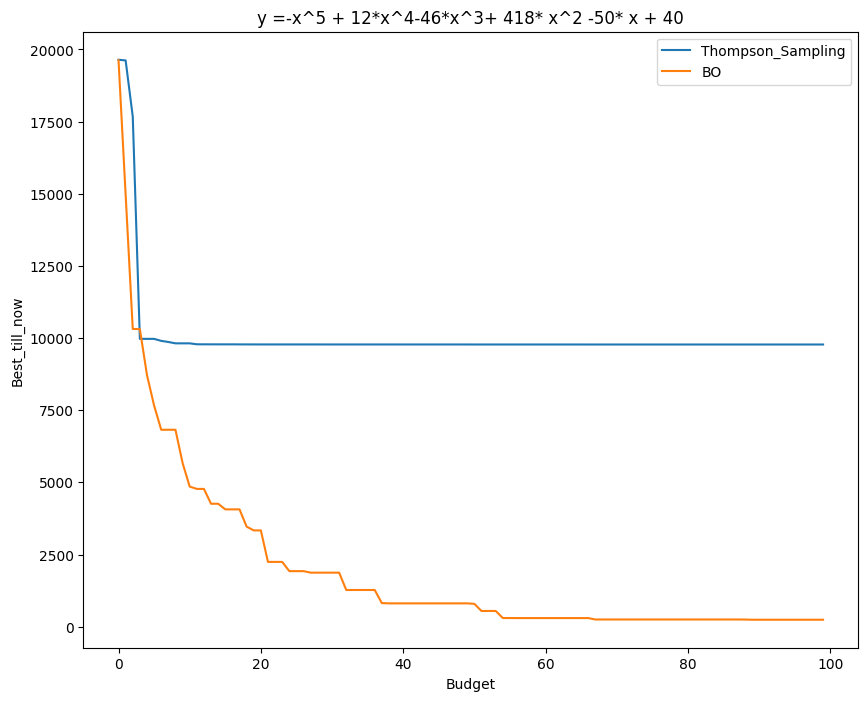

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(best_till_tmp_avg,label = "Thompson_Sampling")
plt.plot(best_till_Bo_averaged,label = "BO")
plt.xlabel("Budget")
plt.ylabel("Best_till_now")
plt.title("y =-x^5 + 12*x^4-46*x^3+ 418* x^2 -50* x + 40")
plt.legend()
plt.savefig("Result_for_second_test_function.png")